# CIFAR-10 luokittelua konvoluutioverkolla
CIFAR-10 datasetti koostuu 60.000 32x32 kuvasta, jotka esittävät 10 eri aihetta.

## Setup
Ensimmäisessä solussa aloitamme asettamalla Kerasille yhteyden Tensorflowiin, sekä tuomme tarvittavat kirjastot

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import backend as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
print(K.backend())

tensorflow


In [12]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Muunnetaan kuva pikseleiksi ja skaalataan arvot välille [0, 1]
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Määritetään kuvan esikäsittelykerros
# Zoomaa ja pyörittää kuvaa silleen et se on aina vähän eri näköinen
preprocessing_pipeline = keras.Sequential([
    layers.RandomFlip(),
])

# Layerit CNN mallille
# Input layer on kuvan koko
inputs = keras.Input((32, 32, 3))

# Kuvan esikäsittelykerros
#x = preprocessing_pipeline(inputs)

# Konvoluutio kerros
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)

# Normalisointi kerros joka normalisoi kerroksen outputin keskiarvon ja varianssin
# Tämä nopeuttaa oppimista ja vähentää overfittingiä
x = layers.BatchNormalization()(x)

# Max pooling kerros joka zoomaa kuvaa
# Tämä vähentää kuvan kokoa ja siten vähentää parametrimäärää
x = layers.MaxPooling2D((2, 2))(x)

# Dropout kerros joka tiputtaa osan inputista nollaksi
# Tämä vähentää overfittingiä
x = layers.Dropout(0.2)(x)

# Ja sama uudestaan
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Lopuksi Flatten kerros joka muuttaa 3D tensorin 1D tensoriksi
# Tämä on tarpeellista ennen kuin voidaan käyttää Dense kerroksia (Output on dense kerros)
# Tän jälkeen vois vielä olla jotain dense kerroksia
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

# Määritetään malli
model = keras.Model(inputs=inputs, outputs=outputs, name='cifar10_model')
model.summary()
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(0.002),
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=7,
    min_delta=0.001,
    restore_best_weights=True
    )

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=0.00001
)

# Treeni
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2, 
                    callbacks=[early_stopping, reduce_lr])

# Annetaan mallille tentti
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Model: "cifar10_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        23,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,570 (166.29 KB)

 Trainable params: 42,506 (166.04 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.4162 - loss: 1.6519 - val_accuracy: 0.4885 - val_loss: 1.5039 - learning_rate: 0.0020
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.6006 - loss: 1.1456 - val_accuracy: 0.6068 - val_loss: 1.1440 - learning_rate: 0.0020
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.6533 - loss: 1.0090 - val_accuracy: 0.6370 - val_loss: 1.0628 - learning_rate: 0.0020
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.6843 - loss: 0.9102 - val_accuracy: 0.6384 - val_loss: 1.0379 - learning_rate: 0.0020
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.6955 - loss: 0.8773 - val_accuracy: 0.6606 - val_loss: 0.9980 - learning_rate: 0.0020
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7072 - loss: 0.8424 - val_accuracy: 0.6691 - val_loss: 0.9805 - learning_rate: 0.0020
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


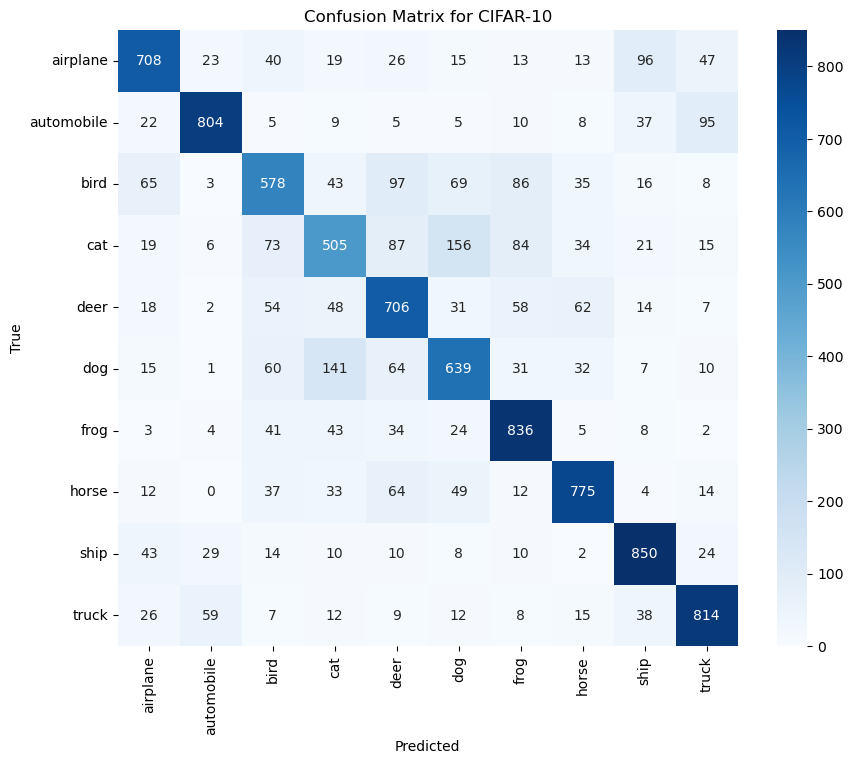

In [15]:
# Confusion matrix
y_test_copy = y_test
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_copy = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_copy, y_pred)
plt.figure(figsize=(10, 8))

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-10')
plt.show()